# Weight Initializations and BatchNorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
torch.set_printoptions(linewidth=140)

In [3]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [4]:
chars = ["."] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}

In [5]:
# Initialize hyperparameters
block_size = 3
embedding_size = 4
hidden_layer_size = 200
batch_size = 64

In [6]:
def build_dataset(words, block_size=3, verbose=False):
    X, Y = [], []
    for word in words:
        padded_word = ["."] * block_size + list(word) + ["."]
        for i in range(len(padded_word)-block_size):
            context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
            target = char_to_ix[padded_word[i+block_size]]
            X.append(context), Y.append(target)
    X, Y = torch.tensor(X), torch.tensor(Y)
    if verbose:
        print(f"{X.shape}\t{Y.shape}")
    return X, Y

random.seed(5)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size=block_size, verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=block_size, verbose=True)
X_test, Y_test = build_dataset(words[n2:], block_size=block_size, verbose=True)

torch.Size([182558, 3])	torch.Size([182558])
torch.Size([22712, 3])	torch.Size([22712])
torch.Size([22876, 3])	torch.Size([22876])


In [7]:
# initialize parameters
g = torch.Generator().manual_seed(5)
C = torch.randn((len(chars), embedding_size), generator=g)
W1 = torch.randn((block_size*embedding_size, hidden_layer_size), generator=g) * (5/3)/(block_size*embedding_size)**0.5
W2 = torch.randn((hidden_layer_size, len(chars)), generator=g) * 1/(hidden_layer_size)**0.5
b2 = torch.zeros((len(chars)))

# batchnorm parameters
bngain = torch.ones((1, hidden_layer_size))
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

Number of parameters: 8335


In [8]:
learning_rate = 0.1
max_steps = 50_000

losses = []

for step in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X_tr[ix]]
    h_in = emb.view(-1, block_size*embedding_size)
    h_preact = h_in @ W1
    bnmean, bnstd = h_preact.mean(dim=0, keepdim=True), h_preact.std(dim=0, keepdim=True)
    h_preact = bngain * (h_preact - bnmean) / bnstd + bnbias
    h_out = torch.tanh(h_preact)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    losses.append(loss.item())
    
    # update running mean and std
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmean
        bnstd_running = 0.999*bnstd_running + 0.001*bnstd
    
    # backward pass
    h_out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    if step % 10_000 == 0:
        print(f'{step}/{max_steps} \t {loss.item()}')

0/50000 	 3.3867897987365723
10000/50000 	 2.0129897594451904
20000/50000 	 2.3968429565429688
30000/50000 	 1.9182183742523193
40000/50000 	 2.240971088409424


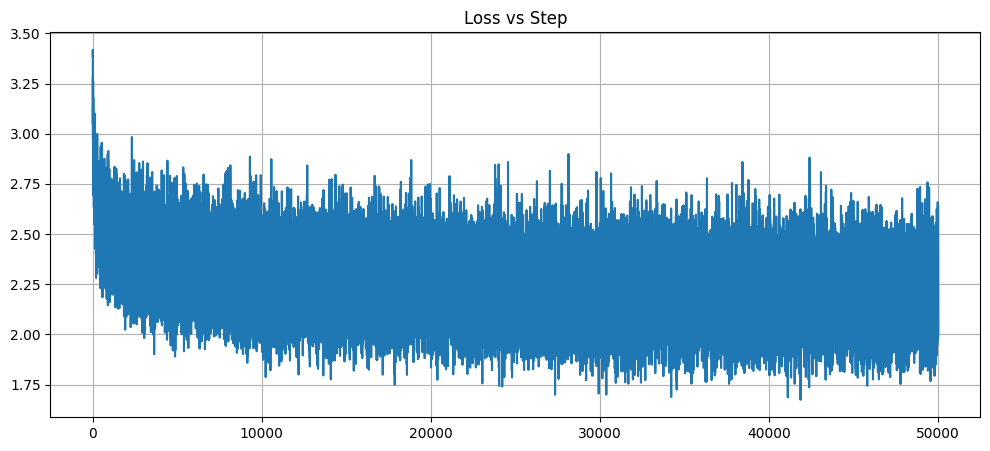

In [9]:
plt.figure(figsize=(12,5)); plt.title("Loss vs Step"); plt.plot(losses); plt.grid();

In [10]:
@torch.no_grad() # disables gradient tracking
def evaluate(X, Y):
    emb = C[X]
    h_in = emb.view(-1, block_size*embedding_size)
    h_preact = h_in @ W1
    h_preact = bngain * (h_preact - bnmean_running) / bnstd_running + bnbias
    h_out = torch.tanh(h_preact)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [11]:
print(f"Training split loss: {evaluate(X_tr, Y_tr):.4f}")
print(f"Development split loss: {evaluate(X_dev, Y_dev):.4f}")

Training split loss: 2.1753
Development split loss: 2.2126


### Evaluate

In [12]:
print(f"Test split loss: {evaluate(X_test, Y_test):.4f}")

Test split loss: 2.2023


In [13]:
with torch.no_grad():
    g = torch.Generator().manual_seed(5)
    for _ in range(20):
        context = ["."] * block_size
        out = []
        while True:
            emb = C[torch.tensor([char_to_ix[char] for char in context])]
            h_in = emb.view(-1, block_size*embedding_size)
            h_preact = h_in @ W1
            h_preact = bngain * (h_preact - bnmean_running) / bnstd_running + bnbias
            h_out = torch.tanh(h_preact)
            logits = h_out @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            if ix==0:
                break
            char = ix_to_char[ix] # type: ignore
            context = context[1:] + [char]
            out.append(char)
        print("".join(out), end="\n")

karyus
kima
les
zosamariel
harvilio
tep
alajendo
zioas
kori
hucindaryseesandrick
tanye
noy
kion
corrin
aaylyn
sliniditzaysin
oluw
zathinitayvery
kriza
ram
